In [116]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [45]:
final = pd.read_csv('/Users/sahana_krishnaraj/Github/siting-optimizer-lmichallange/true_final.csv')
county = gpd.read_file('/Users/sahana_krishnaraj/Github/siting-optimizer-lmichallange/tl_2025_us_county/tl_2025_us_county.shp')
state = gpd.read_file('/Users/sahana_krishnaraj/Github/siting-optimizer-lmichallange/tl_2025_us_state/tl_2025_us_state.shp')


'''
things we want:
low wfh, low drought, high wind plan, high gas and oil production?

things imma do:
fill the gas, oil, wind nas with 0s
County X dominates county Y if X is at least as good in all objectives and strictly better in at least one. dominating means out competes
'''

In [46]:
final.head()
final
county.head()


,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,40,075,01101825,40075,0500000US40075,Kiowa,Kiowa County,06,H1,G4020,None,None,None,A,2629039892,40296743,+34.9214893,-098.9816168,"POLYGON ((-98.95506 35.11643, -98.94903 35.116..."
1,46,079,01265776,46079,0500000US46079,Lake,Lake County,06,H1,G4020,None,None,None,A,1457916151,31746795,+44.0284497,-097.1232229,"POLYGON ((-96.88886 43.9353, -96.88886 43.9351..."
2,37,033,01008542,37033,0500000US37033,Caswell,Caswell County,06,H1,G4020,None,None,None,A,1102042927,8293623,+36.3943252,-079.3396193,"POLYGON ((-79.14343 36.4422, -79.14345 36.4418..."
3,48,377,01383974,48377,0500000US48377,Presidio,Presidio County,06,H1,G4020,None,None,None,A,9985057447,1773188,+30.0058912,-104.2616192,"POLYGON ((-104.98078 30.62552, -104.98073 30.6..."
4,39,057,01074041,39057,0500000US39057,Greene,Greene County,06,H1,G4020,212,19430,None,A,1071302625,6798109,+39.6874785,-083.8948943,"POLYGON ((-84.10668 39.68891, -84.10662 39.689..."


In [47]:
state.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,1,2,36,01779796,36,0400000US36,NY,New York,00,G4000,A,122049344560,19256566831,+42.9133974,-075.5962723,"MULTIPOLYGON (((-74.72623 44.99486, -74.72257 ..."
1,4,8,32,01779793,32,0400000US32,NV,Nevada,00,G4000,A,284537074263,1839852286,+39.3310928,-116.6151469,"POLYGON ((-119.32418 41.99392, -119.32362 41.9..."
2,4,9,02,01785533,02,0400000US02,AK,Alaska,00,G4000,A,1479893380150,244326118163,+63.3473560,-152.8397334,"MULTIPOLYGON (((-167.55823 60.22436, -167.5567..."
3,9,0,60,01802701,60,0400000US60,AS,American Samoa,00,G4000,A,197759070,1307243751,-14.2668475,-170.6671854,"MULTIPOLYGON (((-168.22527 -14.53591, -168.224..."
4,1,1,50,01779802,50,0400000US50,VT,Vermont,00,G4000,A,23872664356,1030573104,+44.0589536,-072.6710173,"POLYGON ((-72.04187 44.15665, -72.0418 44.1566..."


In [17]:
final.isna().sum() 

State                               137
County                              531
GEOID                                 0
Latitude                              0
Longitude                             0
geometry                              0
Gas Production Quantity             774
Oil Production Quantity            1085
Wind Plant Capacity                 505
Wildfire Hazard Potential Score     137
Drought Risk Score                  137
dtype: int64

In [48]:
# List of columns to check
cols_to_check = ["County", "State"]

# Filter rows where all these columns are NaN
all_missing = final[final[cols_to_check].isna().all(axis=1)]

# Count how many rows satisfy this
count_all_missing = all_missing.shape[0]

print(count_all_missing)
all_missing.head()

64


,State,County,GEOID,Latitude,Longitude,geometry,Gas Production Quantity,Oil Production Quantity,Wind Plant Capacity,Wildfire Hazard Potential Score,Drought Risk Score
54,NaN,NaN,22057,28.68700,-90.31300,POINT (-90.313 28.687),0.469242,0.015242,NaN,NaN,NaN
60,NaN,NaN,22075,28.79175,-89.05575,POINT (-89.05575 28.79175),0.349765,0.143186,NaN,NaN,NaN
62,NaN,NaN,22075,28.85900,-88.95800,POINT (-88.958 28.859),0.250829,0.141929,NaN,NaN,NaN
66,NaN,NaN,22075,28.93975,-89.70200,POINT (-89.702 28.93975),0.256738,NaN,NaN,NaN,NaN
68,NaN,NaN,22075,28.95980,-88.60840,POINT (-88.6084 28.9598),NaN,0.245016,NaN,NaN,NaN


In [79]:
countstate = pd.merge(county, state[["STATEFP","STUSPS","NAME"]], on="STATEFP", how="left")
countstate.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME_x,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,STUSPS,NAME_y
0,40,075,01101825,40075,0500000US40075,Kiowa,Kiowa County,06,H1,G4020,...,None,None,A,2629039892,40296743,+34.9214893,-098.9816168,"POLYGON ((-98.95506 35.11643, -98.94903 35.116...",OK,Oklahoma
1,46,079,01265776,46079,0500000US46079,Lake,Lake County,06,H1,G4020,...,None,None,A,1457916151,31746795,+44.0284497,-097.1232229,"POLYGON ((-96.88886 43.9353, -96.88886 43.9351...",SD,South Dakota
2,37,033,01008542,37033,0500000US37033,Caswell,Caswell County,06,H1,G4020,...,None,None,A,1102042927,8293623,+36.3943252,-079.3396193,"POLYGON ((-79.14343 36.4422, -79.14345 36.4418...",NC,North Carolina
3,48,377,01383974,48377,0500000US48377,Presidio,Presidio County,06,H1,G4020,...,None,None,A,9985057447,1773188,+30.0058912,-104.2616192,"POLYGON ((-104.98078 30.62552, -104.98073 30.6...",TX,Texas
4,39,057,01074041,39057,0500000US39057,Greene,Greene County,06,H1,G4020,...,19430,None,A,1071302625,6798109,+39.6874785,-083.8948943,"POLYGON ((-84.10668 39.68891, -84.10662 39.689...",OH,Ohio


In [90]:
final['GEOID'] = final['GEOID'].astype(str)
final["GEOIDlen"] = final['GEOID'].str.len()
final["GEOIDlen"].value_counts()
final['GEOID'] = final['GEOID'].str.zfill(5)
final = final.drop(columns=['GEOIDlen'])
final['GEOID'] = final['GEOID'].astype('int64')


In [89]:
final.GEOID.dtype
countstate['GEOID'] = countstate['GEOID'].astype(str)
countstate['GEOIDlen'] = countstate['GEOID'].str.len()
countstate = countstate.drop(columns=['GEOIDlen'])
countstate['GEOID'] = countstate['GEOID'].astype('int64')


In [91]:
#merge final and countstate
merged = pd.merge(final, countstate[["NAMELSAD","STUSPS","NAME_y","GEOID"]], on="GEOID", how="left")
merged.head()

,State,County,GEOID,Latitude,Longitude,geometry,Gas Production Quantity,Oil Production Quantity,Wind Plant Capacity,Wildfire Hazard Potential Score,Drought Risk Score,NAMELSAD,STUSPS,NAME_y
0,HI,Hawaii County,15001,18.9780,-155.6880,POINT (-155.688 18.978),NaN,NaN,0.334645,0.117,0.106041,Hawaii County,HI,Hawaii
1,HI,Maui County,15009,20.8001,-156.5390,POINT (-156.539 20.8001),NaN,NaN,0.334645,0.100,0.181957,Maui County,HI,Hawaii
2,HI,Honolulu County,15003,21.6692,-157.9501,POINT (-157.9501 21.6692),NaN,NaN,0.371260,0.197,0.044702,Honolulu County,HI,Hawaii
3,HI,Honolulu County,15003,21.6804,-157.9820,POINT (-157.982 21.6804),NaN,NaN,0.382505,0.197,0.044702,Honolulu County,HI,Hawaii
4,TX,Cameron County,48061,26.1189,-97.3431,POINT (-97.3431 26.1189),NaN,NaN,0.540691,0.103,0.000000,Cameron County,TX,Texas


In [101]:
#merged.drop(merged[merged["STUSPS"].isna()].index, inplace=True)
# = merged.drop()
#merged = merged.drop(columns=['State', 'County'])
merged.rename(columns={"STUSPS": "State", "County": "State Name","NAMELSAD":"County"}, inplace=True)
merged.head()

,GEOID,Latitude,Longitude,geometry,Gas Production Quantity,Oil Production Quantity,Wind Plant Capacity,Wildfire Hazard Potential Score,Drought Risk Score,County,State,State Name
0,15001,18.9780,-155.6880,POINT (-155.688 18.978),NaN,NaN,0.334645,0.117,0.106041,Hawaii County,HI,Hawaii
1,15009,20.8001,-156.5390,POINT (-156.539 20.8001),NaN,NaN,0.334645,0.100,0.181957,Maui County,HI,Hawaii
2,15003,21.6692,-157.9501,POINT (-157.9501 21.6692),NaN,NaN,0.371260,0.197,0.044702,Honolulu County,HI,Hawaii
3,15003,21.6804,-157.9820,POINT (-157.982 21.6804),NaN,NaN,0.382505,0.197,0.044702,Honolulu County,HI,Hawaii
4,48061,26.1189,-97.3431,POINT (-97.3431 26.1189),NaN,NaN,0.540691,0.103,0.000000,Cameron County,TX,Texas


In [104]:
# For production columns: NA = 0 (no production = no resource)
merged['Wind Plant Capacity'] = merged['Wind Plant Capacity'].fillna(0)
merged['Oil Production Quantity'] = merged['Oil Production Quantity'].fillna(0)
merged['Gas Production Quantity'] = merged['Gas Production Quantity'].fillna(0)

# For risk columns: NA = median (unknown risk = average risk)
merged['Wildfire Hazard Potential Score'] = merged['Wildfire Hazard Potential Score'].fillna(merged['Wildfire Hazard Potential Score'].median())
merged['Drought Risk Score'] = merged['Drought Risk Score'].fillna(merged['Drought Risk Score'].median())


In [107]:
merged["Pareto Efficient"] = True #intialize the column with the true value
merged.head()


,GEOID,Latitude,Longitude,geometry,Gas Production Quantity,Oil Production Quantity,Wind Plant Capacity,Wildfire Hazard Potential Score,Drought Risk Score,County,State,State Name,Pareto Efficient
0,15001,18.9780,-155.6880,POINT (-155.688 18.978),0.0,0.0,0.334645,0.117,0.106041,Hawaii County,HI,Hawaii,True
1,15009,20.8001,-156.5390,POINT (-156.539 20.8001),0.0,0.0,0.334645,0.100,0.181957,Maui County,HI,Hawaii,True
2,15003,21.6692,-157.9501,POINT (-157.9501 21.6692),0.0,0.0,0.371260,0.197,0.044702,Honolulu County,HI,Hawaii,True
3,15003,21.6804,-157.9820,POINT (-157.982 21.6804),0.0,0.0,0.382505,0.197,0.044702,Honolulu County,HI,Hawaii,True
4,48061,26.1189,-97.3431,POINT (-97.3431 26.1189),0.0,0.0,0.540691,0.103,0.000000,Cameron County,TX,Texas,True


In [113]:
minimize = ["Wildfire Hazard Potential Score", "Drought Risk Score"]
maximize = ["Wind Plant Capacity", "Oil Production Quantity", "Gas Production Quantity"]
for i in range(len(merged)):
    for j in range(len(merged)): #nested loop to comare within 
        if i == j:
            continue #skip the same row comparison -- redundant
        # check if row j is better than row i
        #all() function returns true if all elements in the iterable are true

        #the alls ensure that for a row to dominate another row, it has to be better in all the minimize and maximize columns
        all_min = all(merged.iloc[j][minimize] <= merged.iloc[i][minimize]) #checks each column in current row and compares it with the column in the previous row (dominates if they are lower than previous good!)
        all_max = all(merged.iloc[j][maximize] >= merged.iloc[i][maximize]) #checks each column in current row and compares it with the column in the previous row (dominates if they are higher than previous good!)
        
        #the anys ensure that for a row to dominate another row, it has to be strictly better in at least one of the minimize or maximize columns (like an edge case for when two rows have same values but how do u see if its better)
        any_strict = any(merged.iloc[j][minimize] < merged.iloc[i][minimize]) or \
            any(merged.iloc[j][maximize] > merged.iloc[i][maximize])

        #finally check if all conditions are met
        if all_min and all_max and any_strict:
            merged.iloc[i, merged.columns.get_loc("Pareto Efficient")] = False
            break #no need to check further, move to next row

KeyboardInterrupt: 

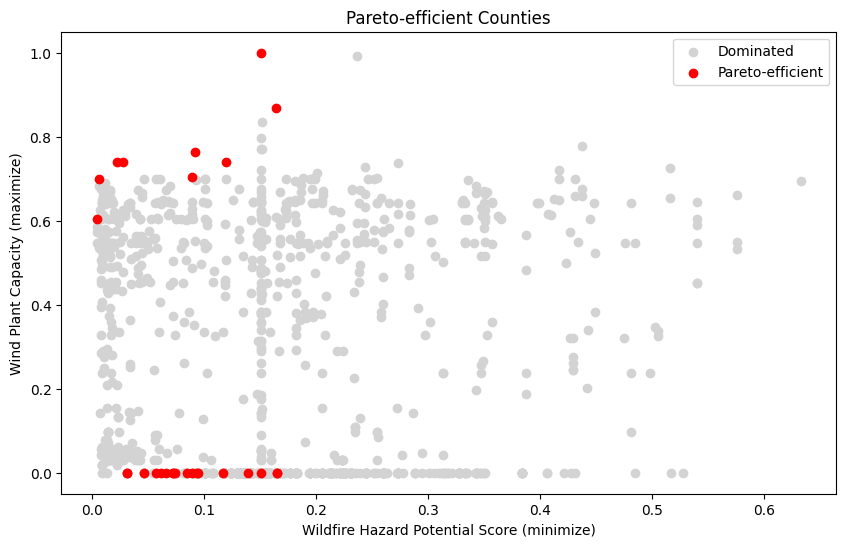

In [117]:
import matplotlib.pyplot as plt

# Pareto efficient vs dominated
pareto_true = merged[merged["Pareto Efficient"] == True]
pareto_false = merged[merged["Pareto Efficient"] == False]

plt.figure(figsize=(10,6))
plt.scatter(pareto_false["Wildfire Hazard Potential Score"], pareto_false["Wind Plant Capacity"], 
            color='lightgray', label='Dominated')
plt.scatter(pareto_true["Wildfire Hazard Potential Score"], pareto_true["Wind Plant Capacity"], 
            color='red', label='Pareto-efficient')
plt.xlabel("Wildfire Hazard Potential Score (minimize)")
plt.ylabel("Wind Plant Capacity (maximize)")
plt.title("Pareto-efficient Counties")
plt.legend()
plt.show()


In [125]:
merged.to_csv("true_final.csv", index=False)

In [127]:
final_csv = merged

In [128]:
final_csv.columns

Index(['GEOID', 'Latitude', 'Longitude', 'geometry', 'Gas Production Quantity',
       'Oil Production Quantity', 'Wind Plant Capacity',
       'Wildfire Hazard Potential Score', 'Drought Risk Score', 'County',
       'State', 'State Name', 'Pareto Efficient'],
      dtype='object')